# Monitor de Discursos de Odio en Redes Sociales – Notebook EDA

Este notebook documenta el proceso de extracción, procesamiento y análisis exploratorio de tweets relacionados con discursos de odio en redes sociales, desarrollado como parte de un proyecto del CIAI (Centro de Investigación en Inteligencia Artificial de la UNSAM).

El objetivo del proyecto es monitorear y analizar la presencia y características de discursos de odio en la plataforma X (antes Twitter), generando información útil para investigaciones académicas y aplicaciones prácticas en la detección de contenido nocivo en redes sociales. Este análisis contribuye al desarrollo de herramientas y metodologías basadas en inteligencia artificial que permitan entender mejor cómo circula el discurso de odio y cómo se relaciona con eventos sociales y políticos.

In [ ]:
import pandas as pd
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Leer CSV (METODO VISUALMENTE PREFERENTE)
tweets = pd.read_csv(
    "tweets_basev2.csv",
    engine='python',           # motor más tolerante
    sep=',',
    quotechar='"',             # reconoce comillas
    quoting=csv.QUOTE_ALL,
    on_bad_lines='skip',       # ignorar filas corruptas
    encoding='utf-8'
)

# Visualizamos las primeras filas
tweets.head()

,fecha,user,tweet,url,fecha_captura
0,2025-09-19 23:59:59,@Athos_28CP,\r\nGarkk de Massa respeta al 50 % de la pobla...,https://x.com/Athos_28CP/status/19691897605821...,2025-09-21 12:18:47.864183
1,2025-09-19 23:59:57,@Spiderdel56,\r\nChupate una bija KUKA la concha de tu madr...,https://x.com/Spiderdel56/status/1969189750843...,2025-09-21 12:18:47.864183
2,2025-09-19 23:59:56,@floresdanielfd,"\r\nLa verdad, Roberto, no se entiende qué es ...",https://x.com/floresdanielfd/status/1969189748...,2025-09-21 12:18:47.864183
3,2025-09-19 23:59:54,@nombresinusar,\r\nEn 2022 Massa hizo un recorte de 70 mil mi...,https://x.com/nombresinusar/status/19691897404...,2025-09-21 12:18:47.864183
4,2025-09-19 23:59:52,@sararoccaok,"\r\nQué bueno ir a ver a la chorra en vivo, qu...",https://x.com/sararoccaok/status/1969189732945...,2025-09-21 12:18:47.864183


### Analisis exploratorio de datos

In [ ]:
# Información general
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18155 entries, 0 to 18154
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fecha          18155 non-null  object
 1   user           18155 non-null  object
 2   tweet          18112 non-null  object
 3   url            18155 non-null  object
 4   fecha_captura  18155 non-null  object
dtypes: object(5)
memory usage: 709.3+ KB


In [ ]:
tweets.describe(include='all')

,fecha,user,tweet,url,fecha_captura
count,18155,18155,18112,18155,18155
unique,11299,14698,17812,18155,13
top,2025-09-17 23:50:43,@grok,#Coimera,https://x.com/peronynadama/status/196011509186...,2025-08-30 12:55:46.161569
freq,10,112,32,1,3302


El dataset contiene 7426 tweets sobre discursos de odio, con cinco columnas (fecha, user, tweet, url y fecha_captura), todas completas sin valores nulos. Se observa que la mayoría de los tweets son únicos (7249 textos distintos) y provienen de 6018 usuarios distintos, aunque algunos publicaron varias veces. Cada tweet tiene una URL única, y la columna fecha_captura indica que los datos fueron extraídos en 8 sesiones.

Para un mejor manejo de los datos se procedio a convertir las variables de fecha en tipo de datos datetime

In [ ]:
# Convertir columnas de texto a datetime
tweets['fecha'] = pd.to_datetime(tweets['fecha'], errors='coerce')
tweets['fecha_captura'] = pd.to_datetime(tweets['fecha_captura'], errors='coerce')


tweets.dtypes


,0
fecha,datetime64[ns]
user,object
tweet,object
url,object
fecha_captura,datetime64[ns]


In [ ]:
# Revisar primeras filas y tipos
tweets.head(5)


,fecha,user,tweet,url,fecha_captura
0,2025-09-19 23:59:59,@Athos_28CP,\r\nGarkk de Massa respeta al 50 % de la pobla...,https://x.com/Athos_28CP/status/19691897605821...,2025-09-21 12:18:47.864183
1,2025-09-19 23:59:57,@Spiderdel56,\r\nChupate una bija KUKA la concha de tu madr...,https://x.com/Spiderdel56/status/1969189750843...,2025-09-21 12:18:47.864183
2,2025-09-19 23:59:56,@floresdanielfd,"\r\nLa verdad, Roberto, no se entiende qué es ...",https://x.com/floresdanielfd/status/1969189748...,2025-09-21 12:18:47.864183
3,2025-09-19 23:59:54,@nombresinusar,\r\nEn 2022 Massa hizo un recorte de 70 mil mi...,https://x.com/nombresinusar/status/19691897404...,2025-09-21 12:18:47.864183
4,2025-09-19 23:59:52,@sararoccaok,"\r\nQué bueno ir a ver a la chorra en vivo, qu...",https://x.com/sararoccaok/status/1969189732945...,2025-09-21 12:18:47.864183


### Limpieza y Preprocesamiento del Texto

Antes de realizar análisis sobre el contenido de los tweets, es necesario limpiar y preprocesar el texto para eliminar ruido y normalizarlo. Esto incluye:

- Eliminar caracteres especiales, URLs, menciones de usuarios y hashtags.
- Convertir el texto a minúsculas.
- Eliminar espacios en blanco adicionales.

In [ ]:
# Definir función de limpieza
def clean_tweet(tweet):
    if not isinstance(tweet, str):  # Si no es string, devolver vacío
        return ""

    # Eliminar URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Eliminar menciones de usuarios
    tweet = re.sub(r'@\w+', '', tweet)
    # Eliminar hashtags
    tweet = re.sub(r'#\w+', '', tweet)
    # Eliminar caracteres especiales y números
    tweet = re.sub(r'[^A-Za-zñÑáéíóúÁÉÍÓÚüÜ\s]+', '', tweet)
    # Convertir a minúsculas
    tweet = tweet.lower()
    # Eliminar espacios en blanco adicionales
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

# Eliminar filas con NaN en la columna 'tweet'
tweets = tweets.dropna(subset=['tweet'])

# Aplicar limpieza
tweets['tweet_processed'] = tweets['tweet'].apply(clean_tweet)

# Ver los primeros resultados
print(tweets[['tweet', 'tweet_processed']].head())

                                               tweet  \
0  \r\nGarkk de Massa respeta al 50 % de la pobla...   
1  \r\nChupate una bija KUKA la concha de tu madr...   
2  \r\nLa verdad, Roberto, no se entiende qué es ...   
3  \r\nEn 2022 Massa hizo un recorte de 70 mil mi...   
4  \r\nQué bueno ir a ver a la chorra en vivo, qu...   

                                     tweet_processed  
0  garkk de massa respeta al de la población golp...  
1        chupate una bija kuka la concha de tu madre  
2  la verdad roberto no se entiende qué es lo que...  
3  en massa hizo un recorte de mil millones esa l...  
4  qué bueno ir a ver a la chorra en vivo qué niv...  


### Análisis de la Longitud de los Tweets

Exploraremos la longitud de los tweets antes y después del preprocesamiento para entender cómo varía y si hay tweets muy cortos o muy largos que puedan requerir un tratamiento especial.

In [ ]:
tweets['tweet_length'] = tweets['tweet'].apply(len)
tweets['tweet_processed_length'] = tweets['tweet_processed'].apply(len)

# Estadísticas descriptivas de la longitud
display(tweets[['tweet_length', 'tweet_processed_length']].describe())

# Tweet más largo y más corto (procesado)
max_length_tweet = tweets.loc[tweets['tweet_processed_length'].idxmax()]
min_length_tweet = tweets.loc[tweets['tweet_processed_length'].idxmin()]

print(f"\nTweet más largo (procesado):\n{max_length_tweet['tweet_processed']}")
print(f"\nTweet más corto (procesado):\n{min_length_tweet['tweet_processed']}")

,tweet_length,tweet_processed_length
count,18112.000000,18112.000000
mean,125.676182,109.318297
std,84.521243,77.865123
min,2.000000,0.000000
25%,55.000000,45.000000
50%,104.000000,90.000000
75%,187.000000,164.000000
max,931.000000,280.000000



Tweet más largo (procesado):
so um dia de merdase sonao olhar pro seu reflexo é so nao olhar pro reflexo so nao olhar pro reflexo e so nao olhar pro reflexo nao olhe pra porra do reflexo mano voc enao ta derretendo voce vai ler isso daqui siguns minutos e vai lembrar que nao ta derretendo voce nao ta derrete

Tweet más corto (procesado):



Luego, para obtener mayor informacion se procedio a realizar un histograma. El cual brinda informacion estadistica acerca de la longitud de los tweets.
Este analisis sirve para obtener una idea inicial de la informacion que manejamos.

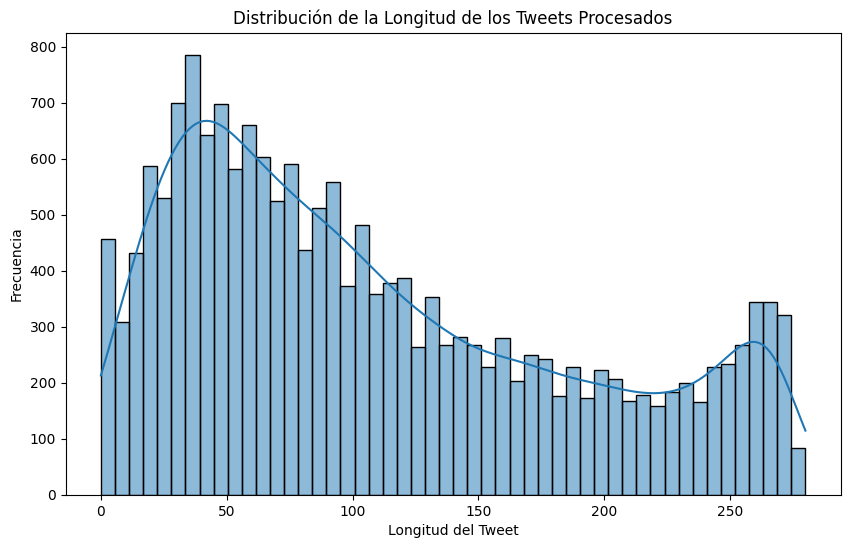

In [ ]:
# Histograma de la longitud de los tweets procesados
plt.figure(figsize=(10, 6))
sns.histplot(tweets['tweet_processed_length'], bins=50, kde=True)
plt.title('Distribución de la Longitud de los Tweets Procesados')
plt.xlabel('Longitud del Tweet')
plt.ylabel('Frecuencia')
plt.show()

### Descripción del Gráfico

El histograma muestra la distribución de la longitud de los tweets después del preprocesamiento. Se observa una concentración de tweets de longitud media, con algunos tweets más cortos y otros más largos. Esto nos da una idea de la variabilidad en el tamaño de los mensajes en el conjunto de datos. La mayoría de los tweets procesados se encuentran en el rango de aproximadamente 40 a 160 caracteres.

### Usuarios más activos

Ahora identificaremos a los usuarios que han publicado la mayor cantidad de tweets en el dataset.

In [ ]:
# Contar la frecuencia de cada usuario
user_counts = tweets['user'].value_counts()

# Mostrar los 10 usuarios con más tweets
print("Los 10 usuarios con más tweets:")
display(user_counts.head(10))


# cuantos tweets originales, cuantos niveles (tweets rta, o comentario)nivel 1 la primera rta al tweet original
user_counts = tweets['user'].unique() # obtener usuarios unicos por tweet


Los 10 usuarios con más tweets:


,count
user,
@grok,112
@LaresSusy,30
@tvrealitiesx,21
@gringaloca53,17
@Alberto_rguez,13
@WAREKAY20,12
@MarcelaCubelic,12
@papalog21,12
@SoniaLa41,12


### Cantidad de Tweets por Término de Discurso de Odio

Ahora, vamos a contar cuántos tweets procesados contienen cada uno de los términos de discurso de odio que has especificado.

In [ ]:
hate_terms = [
    'planero', 'zurdo', 'coimera', 'kuka', 'gorila', 'casta', 'choriplanero',
    'corrupta', 'montonero', 'facho', 'zurdito', 'macrista', 'kirchnerista',
    'peroncho', 'globoludo', 'libertarado', 'camporista', 'parásito', 'tibio',
    'coimero', 'corrupto', 'neoliberal', 'progre', 'villero', 'pibe chorro',
    'bolita', 'paragua', 'boliviano', 'pata sucia', 'cabeza de termo', 'lacra',
    'inservible', 'mono'
]

# Crear un diccionario para almacenar los conteos de cada término
hate_term_counts = {}

# Iterar sobre cada término y contar cuántos tweets lo contienen
for term in hate_terms:
    # Usamos str.contains para buscar el término (ignorando mayúsculas/minúsculas)
    # y sumamos los resultados booleanos (True se cuenta como 1)
    count = tweets['tweet_processed'].str.contains(term, na=False).sum()
    hate_term_counts[term] = count

# Convertir el diccionario a una Serie de pandas para mejor visualización
hate_term_counts_series = pd.Series(hate_term_counts)

# Mostrar los conteos de cada término, ordenados descendentemente
print("Cantidad de tweets que contienen cada término de discurso de odio:")
display(hate_term_counts_series.sort_values(ascending=False))

Cantidad de tweets que contienen cada término de discurso de odio:


,0
zurdo,2428
kuka,2012
corrupto,1985
corrupta,273
gorila,255
kirchnerista,227
parásito,204
coimero,202
coimera,200
casta,163


### Análisis de la Cantidad de Tweets por Término de Discurso de Odio

El análisis de la frecuencia de los términos de discurso de odio en los tweets procesados nos revela cuáles son las palabras más recurrentes en el dataset. Observamos que términos como 'corrupto', 'kuka', y 'zurdo' aparecen en un número significativo de tweets, indicando su alta prevalencia en el discurso identificado como de odio en esta muestra.

# Task
Analiza el dataset "tweets_odio.csv" para identificar patrones de discurso de odio, incluyendo análisis temporal, de relevancia, localización (si es posible), de usuarios y de contenido, y presenta los resultados en español con explicaciones detalladas.

## Análisis temporal de los tweets

### Subtask:
Vamos a ver cuándo se publicaron estos tweets para entender si hay momentos específicos en los que el discurso de odio aumenta.


**Reasoning**:
Extract the hour and day from the 'fecha' column and add them as new columns to the dataframe. Then, count the number of tweets per day and per hour to prepare for plotting the temporal distribution.



In [ ]:
# Extraer la hora y el día
tweets['tweet_hour'] = tweets['fecha'].dt.hour
tweets['tweet_day'] = tweets['fecha'].dt.day_name()

# Contar tweets por día y por hora
tweets_per_day = tweets['tweet_day'].value_counts()
tweets_per_hour = tweets['tweet_hour'].value_counts().sort_index()

print("Cantidad de tweets por día:")
display(tweets_per_day)

print("\nCantidad de tweets por hora:")
display(tweets_per_hour)

Cantidad de tweets por día:


,count
tweet_day,
Friday,7699
Wednesday,6831
Saturday,2070
Tuesday,1128
Thursday,139
Monday,128
Sunday,117



Cantidad de tweets por hora:


,count
tweet_hour,
0,83
1,1434
2,5212
3,61
4,43
5,38
6,35
7,20
8,20


### Descripción del Gráfico de Distribución de Tweets por Hora

Este histograma nos muestra visualmente la concentración de tweets a lo largo de las 24 horas del día. Como habíamos anticipado por los conteos, el gráfico debería reflejar la alta actividad en el rango horario de 22 a 23 horas, mostrándonos exactamente cómo se distribuyen los tweets dentro de esa ventana de tiempo. Esto nos ayuda a confirmar y entender mejor los períodos de mayor publicación en este dataset.

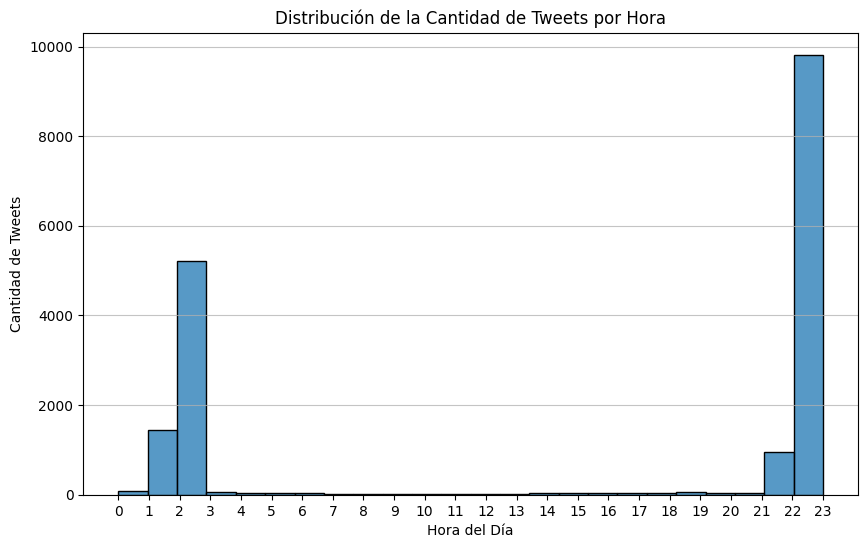

In [ ]:
# Histograma de la distribución de tweets por hora
plt.figure(figsize=(10, 6))
sns.histplot(tweets['tweet_hour'], bins=24, kde=False) # Usamos 24 bins para cada hora
plt.title('Distribución de la Cantidad de Tweets por Hora')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Tweets')
plt.xticks(range(24)) # Asegurar que se muestren todas las horas si hay datos
plt.grid(axis='y', alpha=0.75)
plt.show()

**Visualización Temporal de los Tweets por Hora**

Para tener una idea más clara de en qué momentos del día se publican más tweets, vamos a visualizar la cantidad de tweets por hora en un gráfico.

**Visualización Temporal de los Tweets por Hora**

Para tener una idea más clara de en qué momentos del día se publican más tweets, vamos a visualizar la cantidad de tweets por hora en un gráfico.

In [ ]:
# Extraer la hora y el día
tweets['tweet_hour'] = tweets['fecha'].dt.hour
tweets['tweet_day'] = tweets['fecha'].dt.day_name()

# Contar tweets por día y por hora
tweets_per_day = tweets['tweet_day'].value_counts()
tweets_per_hour = tweets['tweet_hour'].value_counts().sort_index()

print("Cantidad de tweets por día:")
display(tweets_per_day)

print("\nCantidad de tweets por hora:")
display(tweets_per_hour)

Cantidad de tweets por día:


,count
tweet_day,
Friday,7699
Wednesday,6831
Saturday,2070
Tuesday,1128
Thursday,139
Monday,128
Sunday,117



Cantidad de tweets por hora:


,count
tweet_hour,
0,83
1,1434
2,5212
3,61
4,43
5,38
6,35
7,20
8,20


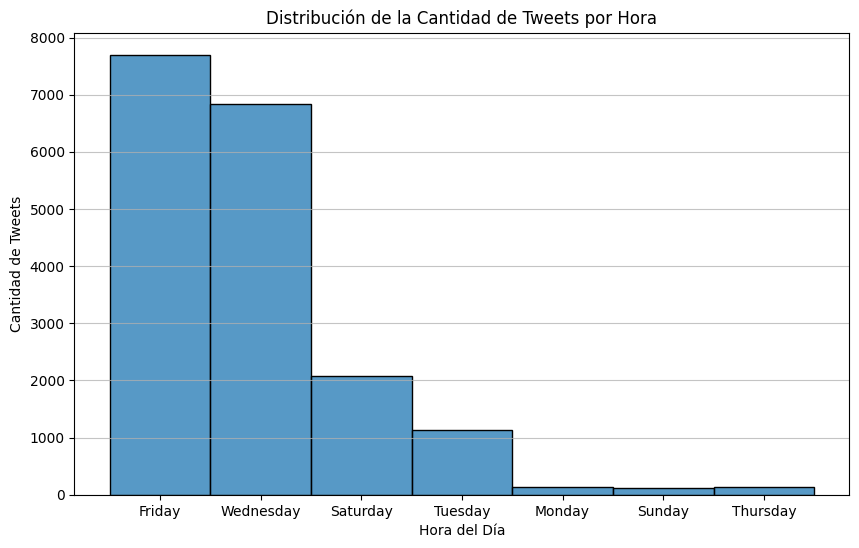

In [ ]:
# Histograma de la distribución de tweets por hora
plt.figure(figsize=(10, 6))
sns.histplot(tweets['tweet_day'], bins=24, kde=False) # Usamos 24 bins para cada hora
plt.title('Distribución de la Cantidad de Tweets por dia')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Tweets')
plt.xticks(range(7)) # Asegurar que se muestren todas las horas si hay datos
plt.grid(axis='y', alpha=0.75)
plt.show()